# Count variants in each sample
This Python Jupyter notebook counts occurrences of each barcode in each sample from Illumina barcode sequencing, and adds these counts to the variant table.

## Set up analysis
### Import Python modules.
Use [plotnine](https://plotnine.readthedocs.io/en/stable/) for ggplot2-like plotting.

The analysis relies heavily on the Bloom lab's [dms_variants](https://jbloomlab.github.io/dms_variants) package:

In [1]:
import itertools
import multiprocessing
import multiprocessing.pool
import os
import warnings

import alignparse
import alignparse.targets

import dms_variants.codonvarianttable
from dms_variants.constants import CBPALETTE
import dms_variants.illuminabarcodeparser
import dms_variants.utils
import dms_variants.plotnine_themes

from IPython.display import display, HTML

import pandas as pd

from plotnine import *

import yaml

Set [plotnine](https://plotnine.readthedocs.io/en/stable/) theme to the gray-grid one defined in `dms_variants`:

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using alignparse version {alignparse.__version__}")
print(f"Using dms_variants version {dms_variants.__version__}")

Using alignparse version 0.2.4
Using dms_variants version 0.8.6


Ignore warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

### Parameters for notebook
Read the configuration file:

In [5]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed:

In [6]:
os.makedirs(config['counts_dir'], exist_ok=True)

## Input variant table
Initialize the input table from the `process_ccs` analysis notebook:

In [7]:
variants = pd.read_csv(config['barcode_variant_table'])

display(HTML(variants.head().to_html(index=False)))

target,library,barcode,substitutions,variant_call_support,number_of_indels
AncSARS1a_tree1,lib1,AAAAAAAAAGTGAAAG,NaN,3,0
ZXC21,lib1,AAAAAAAAAGTTACTA,NaN,4,0
HeB2013,lib1,AAAAAAAAATGAGGAC,NaN,3,0
AncAsia_tree2,lib1,AAAAAAAAATGCCATG,NaN,3,0
AncSARS-CoV-1_alt,lib1,AAAAAAAACACTTAGA,NaN,1,0


Pull out a target sequence for matching to the barcode and flanking sequence regions.

In [8]:
# get wildtype gene sequence for primary target
targets = alignparse.targets.Targets(seqsfile=config['amplicons'],
                                     feature_parse_specs=config['feature_parse_specs'])

## Setup to parse barcodes
Read data frame with list of all barcode runs.
Note how multiple R1 files are delimited by `; ` and are split out separately:

In [9]:
print(f"Reading list of barcode runs from {config['barcode_runs']}")

barcode_runs = (pd.read_csv(config['barcode_runs'])
                .assign(R1=lambda x: x['R1'].str.split('; '))
                )
      
display(HTML(barcode_runs.to_html(index=False)))

Reading list of barcode runs from data/barcode_runs.csv


date,experiment,library,antibody,concentration,concentration_units,group,selection,sample,frac_escape,cells_sorted,R1
201106,expt_68-73,lib1,none,0,ng_per_mL,Vir,reference,expt_68-73-none-0-reference,NaN,NaN,"[/shared/ngs/illumina/tstarr/201123_D00300_1119_BHJKJTBCX3/Unaligned/Project_tstarr/expt68_73_hom_ref_S119_R1_001.fastq.gz, /shared/ngs/illumina/tstarr/201116_D00300_1113_BHJKKFBCX3/Unaligned/Project_tstarr/expt68_73_hom_ref_S23_R1_001.fastq.gz]"
201106,expt_68,lib1,S309,421,ng_per_mL,Vir,escape,expt_68-S309-421-escape,0.490,858224.0,"[/shared/ngs/illumina/tstarr/201123_D00300_1119_BHJKJTBCX3/Unaligned/Project_tstarr/expt70_lib1_Abneg_S126_R1_001.fastq.gz, /shared/ngs/illumina/tstarr/201116_D00300_1113_BHJKKFBCX3/Unaligned/Project_tstarr/expt70_lib1_Abneg_S30_R1_001.fastq.gz]"
201106,expt_69,lib1,S2E12,56,ng_per_mL,Vir,escape,expt_69-S2E12-56-escape,0.890,1754530.0,"[/shared/ngs/illumina/tstarr/201123_D00300_1119_BHJKJTBCX3/Unaligned/Project_tstarr/expt71_lib1_Abneg_S129_R1_001.fastq.gz, /shared/ngs/illumina/tstarr/201116_D00300_1113_BHJKKFBCX3/Unaligned/Project_tstarr/expt71_lib1_Abneg_S33_R1_001.fastq.gz]"
201106,expt_70,lib1,S2X35,70,ng_per_mL,Vir,escape,expt_70-S2X35-70-escape,0.444,864623.0,"[/shared/ngs/illumina/tstarr/201123_D00300_1119_BHJKJTBCX3/Unaligned/Project_tstarr/expt72_lib1_Abneg_S132_R1_001.fastq.gz, /shared/ngs/illumina/tstarr/201116_D00300_1113_BHJKKFBCX3/Unaligned/Project_tstarr/expt72_lib1_Abneg_S36_R1_001.fastq.gz]"
201106,expt_71,lib1,S2X259,59,ng_per_mL,Vir,escape,expt_71-S2X259-59-escape,0.421,805434.0,"[/shared/ngs/illumina/tstarr/201123_D00300_1119_BHJKJTBCX3/Unaligned/Project_tstarr/expt69_lib1_Abneg_S123_R1_001.fastq.gz, /shared/ngs/illumina/tstarr/201116_D00300_1113_BHJKKFBCX3/Unaligned/Project_tstarr/expt69_lib1_Abneg_S27_R1_001.fastq.gz]"
201106,expt_72,lib1,S2X58,18,ng_per_mL,Vir,escape,expt_72-S2X58-18-escape,0.925,1770393.0,"[/shared/ngs/illumina/tstarr/201123_D00300_1119_BHJKJTBCX3/Unaligned/Project_tstarr/expt72_homolog_Abneg_S134_R1_001.fastq.gz, /shared/ngs/illumina/tstarr/201116_D00300_1113_BHJKKFBCX3/Unaligned/Project_tstarr/expt72_homolog_Abneg_S38_R1_001.fastq.gz]"
201106,expt_73,lib1,S304,46,ng_per_mL,Vir,escape,expt_73-S304-46-escape,0.412,817857.0,"[/shared/ngs/illumina/tstarr/201123_D00300_1119_BHJKJTBCX3/Unaligned/Project_tstarr/expt73_homolog_Abneg_S137_R1_001.fastq.gz, /shared/ngs/illumina/tstarr/201116_D00300_1113_BHJKKFBCX3/Unaligned/Project_tstarr/expt73_homolog_Abneg_S41_R1_001.fastq.gz]"
201109,expt_74-78,lib1,none,0,ng_per_mL,Vir,reference,expt_74-78-none-0-reference,NaN,NaN,"[/shared/ngs/illumina/tstarr/201123_D00300_1119_BHJKJTBCX3/Unaligned/Project_tstarr/expt74_78_hom_ref_S161_R1_001.fastq.gz, /shared/ngs/illumina/tstarr/201116_D00300_1113_BHJKKFBCX3/Unaligned/Project_tstarr/expt74_78_hom_ref_S65_R1_001.fastq.gz]"
201109,expt_74,lib1,S2H58,46,ng_per_mL,Vir,escape,expt_74-S2H58-46-escape,0.893,1434377.0,"[/shared/ngs/illumina/tstarr/201123_D00300_1119_BHJKJTBCX3/Unaligned/Project_tstarr/expt74_homolog_Abneg_S140_R1_001.fastq.gz, /shared/ngs/illumina/tstarr/201116_D00300_1113_BHJKKFBCX3/Unaligned/Project_tstarr/expt74_homolog_Abneg_S44_R1_001.fastq.gz]"
201109,expt_75,lib1,S2D106,68,ng_per_mL,Vir,escape,expt_75-S2D106-68-escape,0.890,1494533.0,"[/shared/ngs/illumina/tstarr/201123_D00300_1119_BHJKJTBCX3/Unaligned/Project_tstarr/expt75_homolog_Abneg_S143_R1_001.fastq.gz, /shared/ngs/illumina/tstarr/201116_D00300_1113_BHJKKFBCX3/Unaligned/Project_tstarr/expt75_homolog_Abneg_S47_R1_001.fastq.gz]"


Make sure library / sample combinations are unique:

In [10]:
assert len(barcode_runs) == len(barcode_runs.groupby(['library', 'sample']))

Make sure the the libraries for which we have barcode runs are all in our variant table:

In [11]:
unknown_libs = set(barcode_runs['library']) - set(variants['library'])
if unknown_libs:
    raise ValueError(f"Libraries with barcode runs not in variant table: {unknown_libs}")

Now we initialize an [IlluminaBarcodeParser](https://jbloomlab.github.io/dms_variants/dms_variants.illuminabarcodeparser.html#dms_variants.illuminabarcodeparser.IlluminaBarcodeParser) for each library.

First, get the length of the barcode from the alignment target after making sure the same length for all targets:

In [12]:
bclen = len(targets.targets[0].get_feature('barcode').seq)

assert (bclen == len(target.get_feature('barcode').seq) for target in targets.targets)

print(f"Barcodes of length {bclen}")

Barcodes of length 16


The other barcode parsing params come from the config file:

In [13]:
parser_params = config['illumina_barcode_parser_params']

display(HTML(
    pd.Series(parser_params, name='value')
    .rename_axis(index='parameter')
    .reset_index()
    .to_html(index=False)
    ))

parameter,value
upstream,GGCCGC
downstream,
minq,20
upstream_mismatch,1
downstream_mismatch,0


The parser needs to know the set of valid barcodes, which are stored in the variant table and are different for each library.
So we create a different parser for each library using these valid barcode sets:

In [14]:
# create dict keyed by library, value is parser for library
parsers = {lib: dms_variants.illuminabarcodeparser.IlluminaBarcodeParser(
                    bclen=bclen,
                    valid_barcodes=variants.loc[variants['library']==lib]['barcode'],
                    **parser_params)
           for lib in set(variants['library'])}

print('Number of valid barcodes searched for by each parser:')
display(HTML(
    pd.DataFrame([(lib, len(p.valid_barcodes)) for lib, p in parsers.items()],
                 columns=['library', 'number of valid barcodes'])
    .to_html(index=False)
    ))

Number of valid barcodes searched for by each parser:


library,number of valid barcodes
lib2,23259
lib1,25896


## Parse barcodes
We now parse the barcodes.
Since this will take a while, we utilize multiple CPUs via the Python [multiprocessing](https://docs.python.org/3.6/library/multiprocessing.html) module.
First, determine how many CPUs to use.
We use the minimum of the user-specified number hardcoded below and the number actually available.
(If you are running *interactively* on the Hutch cluster, you may need to reduce the number below in order to avoid an error as there is an enforced CPU limit on the home `rhino` nodes):

In [15]:
ncpus = min(config['max_cpus'], multiprocessing.cpu_count())
print(f"Using {ncpus} CPUs")

Using 16 CPUs


Parse the barcodes in parallel via a [multiprocessing.Pool](https://docs.python.org/3.6/library/multiprocessing.html#multiprocessing.pool.Pool) using all the available CPUs to get a list of the data frames with barcode counts / fates for each sample:

In [16]:
def process_func(parser, r1files, library, sample):
    """Convenience function to be starmapped to multiprocessing pool."""
    return parser.parse(r1files, add_cols={'library': library, 'sample': sample})

# parallel computation of list of data frames
with multiprocessing.pool.Pool(processes=ncpus) as pool:
    bclist = pool.starmap(
                process_func,
                [(parsers[run.library], run.R1, run.library, run.sample)
                  for run in barcode_runs.itertuples()],
                )

Now concatenate the list into data frames of barcode counts and barcode fates:

In [17]:
counts = pd.concat([samplecounts for samplecounts, _ in bclist],
                   sort=False,
                   ignore_index=True)

print('First few lines of counts data frame:')
display(HTML(counts.head().to_html(index=False)))

fates = pd.concat([samplefates for _, samplefates in bclist],
                  sort=False,
                  ignore_index=True)

print('First few lines of fates data frame:')
display(HTML(fates.head().to_html(index=False)))

First few lines of counts data frame:


barcode,count,library,sample
AACGAAACCTCTGTCA,2301,lib1,expt_68-73-none-0-reference
ATTGGCTTACTAAATA,2073,lib1,expt_68-73-none-0-reference
CGATAATATAGACAAG,2051,lib1,expt_68-73-none-0-reference
CGCACAAACTAGTAGT,1855,lib1,expt_68-73-none-0-reference
AATGGAATATTCACAT,1825,lib1,expt_68-73-none-0-reference


First few lines of fates data frame:


fate,count,library,sample
valid barcode,6480493,lib1,expt_68-73-none-0-reference
invalid barcode,2455034,lib1,expt_68-73-none-0-reference
low quality barcode,479114,lib1,expt_68-73-none-0-reference
failed chastity filter,213176,lib1,expt_68-73-none-0-reference
unparseable barcode,103814,lib1,expt_68-73-none-0-reference


## Examine fates of parsed barcodes
First, we'll analyze the "fates" of the parsed barcodes.
These fates represent what happened to each Illumina read we parsed:
 - Did the barcode read fail the Illumina chastity filter?
 - Was the barcode *unparseable* (i.e., the read didn't appear to be a valid barcode based on flanking regions)?
 - Was the barcode sequence too *low quality* based on the Illumina quality scores?
 - Was the barcode parseable but *invalid* (i.e., not in our list of variant-associated barcodes in the codon variant table)?
 - Was the barcode *valid*, and so will be added to variant counts.
 
First, we just write a CSV file with all the barcode fates:

In [18]:
fatesfile = os.path.join(config['counts_dir'], 'barcode_fates.csv')
print(f"Writing barcode fates to {fatesfile}")
fates.to_csv(fatesfile, index=False)

Writing barcode fates to results/counts/barcode_fates.csv


Next, we tabulate the barcode fates in wide format:

In [19]:
display(HTML(fates
             .pivot_table(columns='fate',
                          values='count',
                          index=['library', 'sample'])
             .to_html()
             ))

Now we plot the barcode-read fates for each library / sample, showing the bars for valid barcodes in orange and the others in gray.
We see that the largest fraction of barcode reads correspond to valid barcodes, and most of the others are invalid barcodes (probably because the map to variants that aren't present in our variant table since we didn't associate all variants with barcodes). The exception to this is lib2 Titeseq_03_bin3; the PCR for this sample in the original sequencing run failed, so we followed it up with a single MiSeq lane. We did not filter out the PhiX reads from this data before parsing, so these PhiX reads will deflate the fraction of valid barcode reads as expected, but does not indicate any problems.

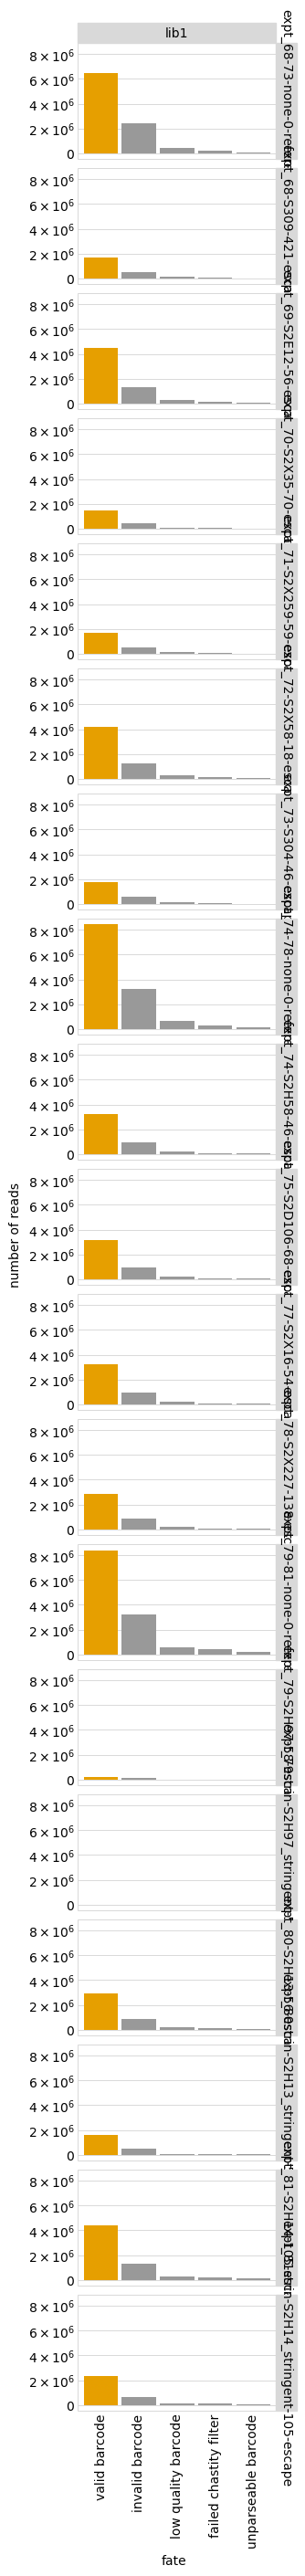

In [20]:
barcode_fate_plot = (
    ggplot(
        fates
        .assign(sample=lambda x: pd.Categorical(x['sample'],
                                                x['sample'].unique(),
                                                ordered=True),
                fate=lambda x: pd.Categorical(x['fate'],
                                              x['fate'].unique(),
                                              ordered=True),
                is_valid=lambda x: x['fate'] == 'valid barcode'
                ), 
        aes('fate', 'count', fill='is_valid')) +
    geom_bar(stat='identity') +
    facet_grid('sample ~ library') +
    facet_grid('sample ~ library') +
    scale_fill_manual(CBPALETTE, guide=False) +
    theme(figure_size=(1.4 * (1 + fates['library'].nunique()),
                       1.7 * (1.2 + fates['sample'].nunique())),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank()
          ) +
    scale_y_continuous(labels=dms_variants.utils.latex_sci_not,
                       name='number of reads')
    )

_ = barcode_fate_plot.draw()

## Output csv of barcode counts

In [21]:
print(f"Writing variant counts to {config['variant_counts']}")
counts.to_csv(config['variant_counts'], index=False)

Writing variant counts to results/counts/variant_counts.csv
